<a href="https://colab.research.google.com/github/devbabbar7/Udacity-Introduction-to-Tensorflow-for-Deep-Learning/blob/main/l08c06_forecasting_with_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting with an RNN

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

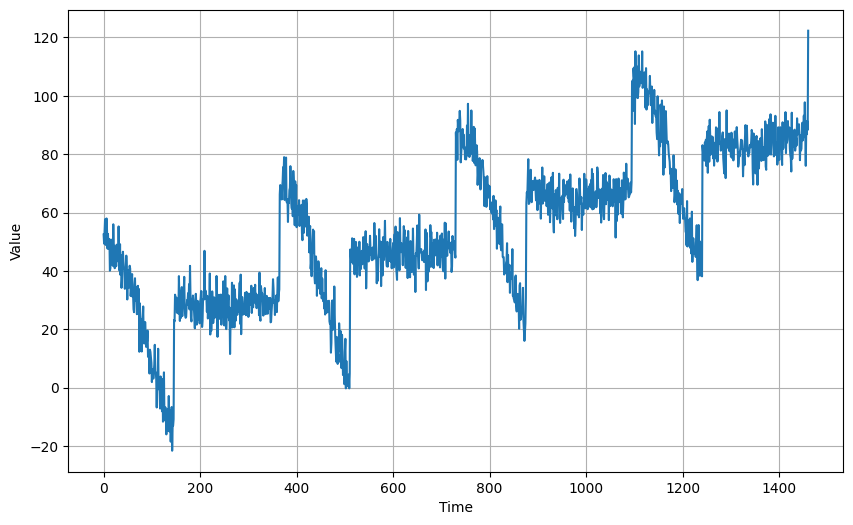

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Simple RNN Forecasting

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 83ms/step - loss: 57.2973 - mae: 57.7956 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 1s 56ms/step - loss: 36.4651 - mae: 36.9617 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 1s 76ms/step - loss: 35.8064 - mae: 36.3036 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 1s 75ms/step - loss: 33.0288 - mae: 33.5275 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 1s 95ms/step - loss: 29.8822 - mae: 30.3748 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 1s 90ms/step - loss: 28.0459 - mae: 28.5431 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 1s 83ms/step - loss: 25.7922 - mae: 26.2889 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 1s 80ms/step - loss: 23.3703 - mae: 23.8655 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 1s 62ms/step - loss: 20.8785 - mae: 21.3716 - lr: 2.5

(1e-07, 0.0001, 0.0, 30.0)

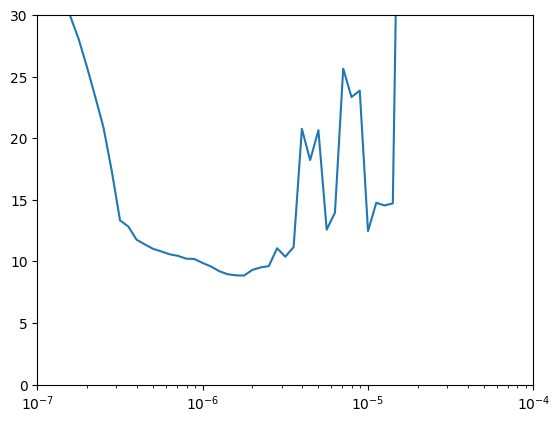

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
      7/Unknown - 2s 36ms/step - loss: 12546.1543 - mae: 12546.6514

8/8 [==============================] - 6s 577ms/step - loss: 13802.3330 - mae: 13802.8311 - val_loss: 28114.8223 - val_mae: 28115.3223
Epoch 2/500
8/8 [==============================] - 1s 58ms/step - loss: 19441.0254 - mae: 19441.5234 - val_loss: 38827.8867 - val_mae: 38828.3867
Epoch 3/500
8/8 [==============================] - 1s 91ms/step - loss: 56865.8516 - mae: 56866.3516 - val_loss: 111201.4688 - val_mae: 111201.9688
Epoch 4/500
8/8 [==============================] - 1s 93ms/step - loss: 41878.9023 - mae: 41879.4062 - val_loss: 43867.2344 - val_mae: 43867.7344
Epoch 5/500
8/8 [==============================] - 1s 58ms/step - loss: 21140.4102 - mae: 21140.9121 - val_loss: 32970.9688 - val_mae: 32971.4727
Epoch 6/500
7/8 [=========================>....] - ETA: 0s - loss: 22623.2617 - mae: 22623.7617

8/8 [==============================] - 3s 471ms/step - loss: 23125.2812 - mae: 23125.7793 - val_loss: 20952.0703 - val_mae: 20952.5684
Epoch 7/500
8/8 [==============================] - 1s 48ms/step - loss: 20324.2617 - mae: 20324.7617 - val_loss: 27497.4707 - val_mae: 27497.9727
Epoch 8/500
8/8 [==============================] - ETA: 0s - loss: 20472.0820 - mae: 20472.5840

8/8 [==============================] - 4s 563ms/step - loss: 20472.0820 - mae: 20472.5840 - val_loss: 20642.1895 - val_mae: 20642.6914
Epoch 9/500
7/8 [=========================>....] - ETA: 0s - loss: 18536.0918 - mae: 18536.5918

8/8 [==============================] - 4s 483ms/step - loss: 18308.1992 - mae: 18308.7012 - val_loss: 12269.0020 - val_mae: 12269.5010
Epoch 10/500
8/8 [==============================] - 1s 53ms/step - loss: 42219.6562 - mae: 42220.1562 - val_loss: 18021.8320 - val_mae: 18022.3340
Epoch 11/500
7/8 [=========================>....] - ETA: 0s - loss: 61343.8672 - mae: 61344.3672

8/8 [==============================] - 3s 473ms/step - loss: 59765.5781 - mae: 59766.0781 - val_loss: 7505.8975 - val_mae: 7506.3975
Epoch 12/500
8/8 [==============================] - 0s 50ms/step - loss: 22454.0469 - mae: 22454.5469 - val_loss: 88630.0859 - val_mae: 88630.5859
Epoch 13/500
8/8 [==============================] - 1s 58ms/step - loss: 74368.0078 - mae: 74368.5000 - val_loss: 101937.2812 - val_mae: 101937.7812
Epoch 14/500
8/8 [==============================] - 1s 57ms/step - loss: 104413.7188 - mae: 104414.2188 - val_loss: 60705.3750 - val_mae: 60705.8750
Epoch 15/500
8/8 [==============================] - 1s 50ms/step - loss: 34378.4883 - mae: 34378.9883 - val_loss: 61906.7969 - val_mae: 61907.2930
Epoch 16/500
8/8 [==============================] - 1s 59ms/step - loss: 40613.1172 - mae: 40613.6172 - val_loss: 21364.5098 - val_mae: 21365.0117
Epoch 17/500
8/8 [==============================] - 1s 107ms/step - loss: 35738.3477 - mae: 35738.8438 - val_loss: 18312.1719 - 

8/8 [==============================] - 4s 536ms/step - loss: 36561.0039 - mae: 36561.5000 - val_loss: 3005.1357 - val_mae: 3005.6357
Epoch 57/500
8/8 [==============================] - 1s 53ms/step - loss: 29755.5449 - mae: 29756.0430 - val_loss: 24345.4922 - val_mae: 24345.9922
Epoch 58/500
8/8 [==============================] - 1s 55ms/step - loss: 40180.8320 - mae: 40181.3320 - val_loss: 7042.6484 - val_mae: 7043.1484
Epoch 59/500
8/8 [==============================] - 1s 58ms/step - loss: 58713.1406 - mae: 58713.6445 - val_loss: 22267.5938 - val_mae: 22268.0957
Epoch 60/500
8/8 [==============================] - 1s 54ms/step - loss: 21160.7461 - mae: 21161.2480 - val_loss: 5327.2812 - val_mae: 5327.7812
Epoch 61/500
8/8 [==============================] - 1s 59ms/step - loss: 65446.6602 - mae: 65447.1602 - val_loss: 75732.4297 - val_mae: 75732.9297
Epoch 62/500
8/8 [==============================] - 1s 92ms/step - loss: 25897.6836 - mae: 25898.1836 - val_loss: 31061.9512 - val_mae: 

In [8]:
model = keras.models.load_model("my_checkpoint")

In [9]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 11ms/step


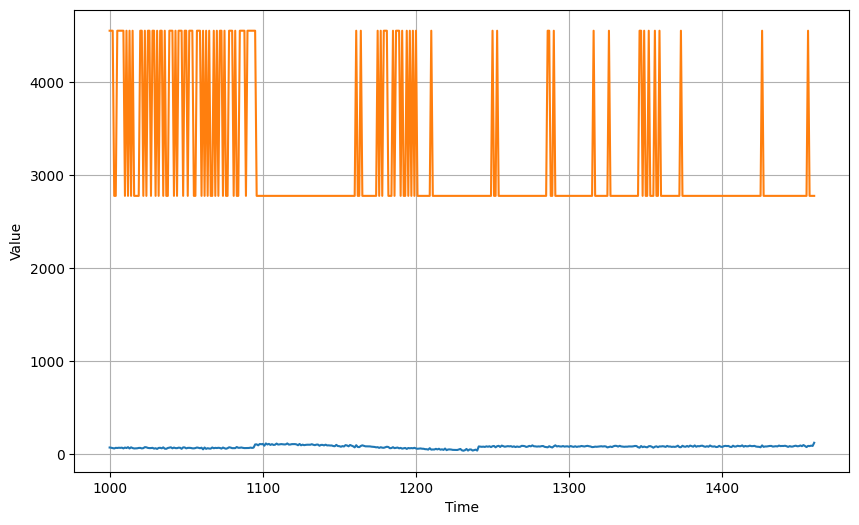

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [11]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

3055.992

## Sequence-to-Sequence Forecasting

In [12]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]


In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 41ms/step - loss: 329.8226 - mae: 330.3226 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 36ms/step - loss: 288.9499 - mae: 289.4499 - lr: 1.0798e-07
Epoch 3/100
8/8 [==============================] - 0s 37ms/step - loss: 220.7481 - mae: 221.2481 - lr: 1.1659e-07
Epoch 4/100
8/8 [==============================] - 0s 35ms/step - loss: 134.0132 - mae: 134.5132 - lr: 1.2589e-07
Epoch 5/100
8/8 [==============================] - 0s 35ms/step - loss: 47.1549 - mae: 47.6517 - lr: 1.3594e-07
Epoch 6/100
8/8 [==============================] - 0s 37ms/step - loss: 47.1633 - mae: 47.6624 - lr: 1.4678e-07
Epoch 7/100
8/8 [==============================] - 1s 56ms/step - loss: 37.3577 - mae: 37.8546 - lr: 1.5849e-07
Epoch 8/100
8/8 [==============================] - 1s 62ms/step - loss: 32.1736 - mae: 32.6661 - lr: 1.7113e-07
Epoch 9/100
8/8 [==============================] - 1s 71ms/step - loss: 29.5503 - mae: 30.0431 -

(1e-07, 0.0001, 0.0, 30.0)

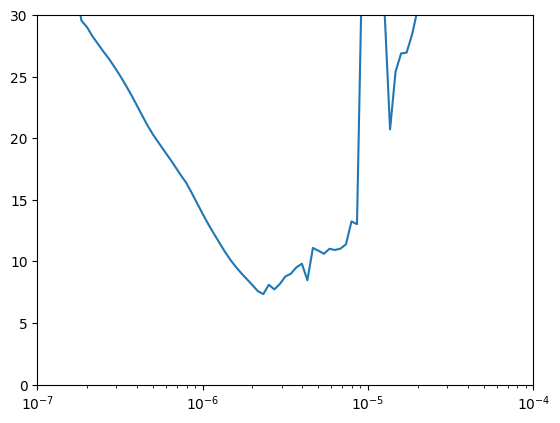

In [15]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 3s 171ms/step - loss: 9228.7988 - mae: 9229.2988 - val_loss: 53154.0703 - val_mae: 53154.5703
Epoch 2/500
8/8 [==============================] - 1s 62ms/step - loss: 42496.5781 - mae: 42497.0781 - val_loss: 737.7089 - val_mae: 738.2089
Epoch 3/500
8/8 [==============================] - 1s 56ms/step - loss: 31769.7637 - mae: 31770.2598 - val_loss: 17288.1582 - val_mae: 17288.6562
Epoch 4/500
8/8 [==============================] - 1s 66ms/step - loss: 28266.8398 - mae: 28267.3438 - val_loss: 55960.8594 - val_mae: 55961.3594
Epoch 5/500
8/8 [==============================] - 1s 114ms/step - loss: 42489.1953 - mae: 42489.6953 - val_loss: 11065.0967 - val_mae: 11065.5967
Epoch 6/500
8/8 [==============================] - 1s 114ms/step - loss: 12744.3438 - mae: 12744.8438 - val_loss: 46685.8086 - val_mae: 46686.3086
Epoch 7/500
8/8 [==============================] - 1s 63ms/step - loss: 41222.2930 - mae: 41222.7969 - val_loss: 5176.2964 - va

In [17]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 1s 11ms/step


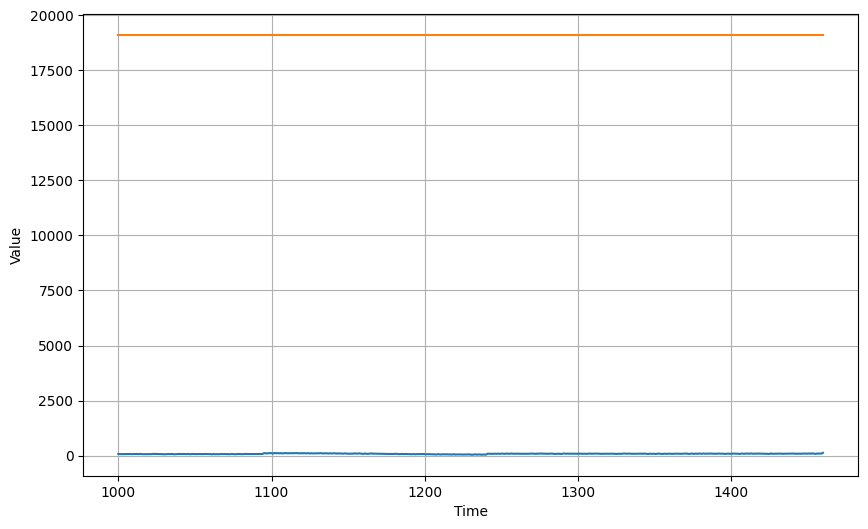

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [19]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

19044.242